In [1]:
import pandas as pd
import scipy.io
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import collections
import json
import matlab.engine
from sklearn.linear_model import LinearRegression
import os
import sys
#os.environ['TMP'] = r'C:/Program Files/MATLAB/R2024b/bin/matlab.exe'
#os.environ['TEMP'] = r'C:/Program Files/MATLAB/R2024b/bin/matlab.exe'
#sys.path.append("matlab24bPy311\Lib\site-packages")

In [ ]:
'''
Load the generator and bus data. Remove renewable generators from the generator dataset. All these datasets come fron CATS paper.
'''
bus = scipy.io.loadmat('MATPOWER/bus.mat')['bus']
power_demand = bus[:, 2]
df = pd.read_csv("GIS/CATS_gens.csv").to_numpy()
#df = df[df['Pmax'] != 0.0].to_numpy()
old_num_gen = len(df)
#df = df.drop_duplicates(subset=['PlantCode','GenID']).to_numpy()
indices = []
idx = []
impt_idx = []
renew_type = ["Solar Photovoltaic", "Solar Thermal without Energy Storage", "Onshore Wind Turbine", "Hydroelectric Pumped Storage", "Conventional Hydroelectric"]
for i, r in enumerate(df):
    if r[3] in renew_type:
        indices.append(i+1)
        idx.append(i)
    if r[3] == "IMPORT":
        impt_idx.append(i+1)
bus_loc = pd.read_csv("GIS/CATS_buses.csv").to_numpy()[:, [4,5]]
gen_loc = df[:, -2:]
df[idx, 5] = 0
#df_renew = pd.read_csv("GIS/CATS_gens.csv").loc[lambda x: idx, :]
eng = matlab.engine.start_matlab()
#real_gen = pd.read_csv('data/CAISO-demand-20191101.csv').iloc[[2]].to_numpy().reshape((290, ))[1:]
g = eng.removeSolar(indices)
g = eng.removeSolar(impt_idx)
m = eng.loadcase('CaliforniaTestSystem.m')
num_bus = np.array(m['bus']).shape[0]
num_branch = np.array(m['branch']).shape[0]
num_gen = np.array(m['gen']).shape[0]
gen_bus_temp = np.array(m['gen'])[:,0]
eng.quit()

In [3]:
for i, v in enumerate(gen_bus_temp):
    if df[i,2] != v:
        print(i)
        break

In [4]:
'''
Check the total power generation by fuel type.
'''
gen_by_fuel = collections.defaultdict(float)
for row in df:
    gen_by_fuel[row[3]] += row[5]
gen_by_fuel

defaultdict(float,
            {'Conventional Hydroelectric': 0.0,
             'Petroleum Liquids': 369.09999999999997,
             'Natural Gas Fired Combustion Turbine': 10893.39999999999,
             'Natural Gas Internal Combustion Engine': 325.5999999999998,
             'Natural Gas Fired Combined Cycle': 19649.300000000007,
             'Natural Gas Steam Turbine': 4744.799999999999,
             'Landfill Gas': 278.6,
             'Batteries': 229.50000000000003,
             'Hydroelectric Pumped Storage': 0.0,
             'Geothermal': 1095.2,
             'Nuclear': 2323.0,
             'Onshore Wind Turbine': 0.0,
             'Other Waste Biomass': 168.5999999999999,
             'Wood/Wood Waste Biomass': 504.8,
             'Solar Photovoltaic': 0.0,
             'Solar Thermal without Energy Storage': 0.0,
             'All Other': 113.69999999999999,
             'Conventional Steam Coal': 55.0,
             'Other Gases': 258.1,
             'Petroleum Coke': 27.3

([<matplotlib.patches.Wedge at 0x1760257e550>,
 [Text(-0.183659912126977, 1.084559374436232, 'Natural Gas'),
  Text(-1.038670975777293, -0.36216378073717737, 'Solar'),
  Text(-0.9912161238433614, -0.4769597423608643, 'Nuclear'),
  Text(-0.9295511066190857, -0.5881621716697133, 'Coal'),
  Text(-0.9279744050661253, -0.5906466824948491, 'Hydro'),
  Text(-0.9074097490549368, -0.6217777314443296, 'Biomass'),
  Text(-0.8617721630072604, -0.6836290946601, 'Other'),
  Text(-0.7974164783174263, -0.7577116602691514, 'Geothermal'),
  Text(-0.755942699658503, -0.7990936333327995, 'Wind'),
  Text(0.40848893227257577, -1.0213406837147, 'Import'),
  Text(1.099625255452701, -0.028710582902164074, 'Biogas')],
 [Text(-0.100178133887442, 0.5915778406015811, '55.3%'),
  Text(-0.5665478049694325, -0.19754388040209672, '0.0%'),
  Text(-0.5406633402781971, -0.2601598594695623, '3.6%'),
  Text(-0.507027876337683, -0.3208157300016618, '0.1%'),
  Text(-0.5061678573087955, -0.3221709177244631, '0.0%'),
  Text(-0

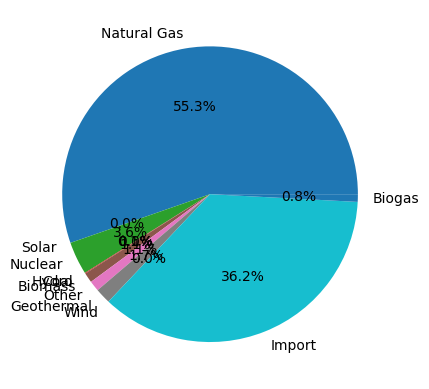

In [5]:
'''
Map the fuel types in our CATS dataset to the ones in paper to check.
'''
y = [0]*11
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        y[0] += v
    elif 'Solar' in k:
        y[1] += v
    elif 'Nuclear' in k:
        y[2] += v
    elif 'Coal' in k:
        y[3] += v
    elif 'Hydro' in k:
        y[4] += v
    elif 'Biomass' in k or 'Waste' in k:
        y[5] += v
    elif 'Geothermal' in k:
        y[7] += v
    elif 'Wind' in k:
        y[8] += v
    elif 'IMPORT' in k:
        y[9] += v
    elif 'Landfill' in k or 'Other Gases' in k:
        y[10] += v
    else:
        y[6] += v
x = ['Natural Gas', 'Solar','Nuclear','Coal','Hydro','Biomass','Other','Geothermal','Wind','Import','Biogas']
fig, ax = plt.subplots()
ax.pie(y, labels=x,autopct='%1.1f%%')

In [6]:
'''
Get the emission data and calculate generator emission rate by each generator fuel type. (tonnes of CO2/MWH). Source: EIA
'''
# https://www.eia.gov/electricity/data/emissions/
gen_emission = pd.read_excel("data/emissions2019.xlsx")
gen_emission = gen_emission[gen_emission['Generation (kWh)'] > 0]
gen_emission = gen_emission[gen_emission['State'] == 'CA']
gen_emission = gen_emission[['Plant Code','Fuel Code','Aggregated Fuel Group','Generation (kWh)','Metric Tonnes of CO2 Emissions','carbon emission rate']]
d1 = gen_emission.groupby(['Aggregated Fuel Group'])['Generation (kWh)'].sum()
d2 = gen_emission.groupby(['Aggregated Fuel Group'])['Metric Tonnes of CO2 Emissions'].sum()
d2*1000/d1
# get carbon emssion rate of each fuel type (tons/mWh)

Aggregated Fuel Group
COAL    4.692794
GAS     0.455939
GEO     0.026307
MSW     0.834946
PET     0.878813
dtype: float64

In [8]:
gen_emission.groupby(['Fuel Code'])['carbon emission rate'].median()

Fuel Code
BIT    4.642909
DFO    1.191675
GEO    0.026307
JF     1.180994
MSW    0.834394
NG     0.585267
PG     1.083609
RC     4.693628
WO     0.534195
Name: carbon emission rate, dtype: float64

In [7]:
'''
Dictionary to store fuel type to emission rate.
'''
type_to_emission = collections.defaultdict(float)
#type_to_emission['Conventional Hydroelectric'] = 0
#type_to_emission['Hydroelectric Pumped Storage'] = 0
type_to_emission['Petroleum Liquids'] = 1.114133
type_to_emission['Natural Gas Internal Combustion Engine'] = 0.455939
type_to_emission['Natural Gas Fired Combined Cycle'] = 0.455939
type_to_emission['Natural Gas Steam Turbine'] = 0.455939
type_to_emission['Natural Gas Fired Combustion Turbine'] = 0.455939
type_to_emission['Nuclear'] = 0
type_to_emission['Geothermal'] = 0.058489
#type_to_emission['Onshore Wind Turbine'] = 0
type_to_emission['Other Waste Biomass'] = 0.029702
type_to_emission['Wood/Wood Waste Biomass'] = 0.029702
type_to_emission['Landfill Gas'] = 0.776560
#type_to_emission['Solar Photovoltaic'] = 0
#type_to_emission['Solar Thermal without Energy Storage'] = 0
type_to_emission['Conventional Steam Coal'] = 0.531497
type_to_emission['Other Gases'] = 0.776560
type_to_emission['Batteries'] = 0
type_to_emission['Petroleum Coke'] = 1.114133
type_to_emission['Municipal Solid Waste'] = 0.029702
type_to_emission['Other Natural Gas'] = 0.455939
type_to_emission['All Other'] = 0.104261
type_to_emission['IMPORT'] = 0.302718
#type_to_emission['Synchronous Condenser'] = 884
'''
for k, v in type_to_emission.items():
    type_to_emission[k] *= 2.7
'''

'\nfor k, v in type_to_emission.items():\n    type_to_emission[k] *= 2.7\n'

In [9]:
'''
Generator emission data from EPA. 
'''
# https://www.epa.gov/egrid
emission_power_plant = pd.read_excel("data/emission_egrid.xlsx")
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant["plant_emission_rate"] = emission_power_plant["Plant annual CO2 emissions"]/emission_power_plant["Plant annual net generation"]
emission_power_plant.groupby(['Plant primary coal/oil/gas/ other fossil fuel category'])['plant_emission_rate'].mean()

Plant primary coal/oil/gas/ other fossil fuel category
BIOMASS       0.031964
COAL          0.574314
GAS           0.392918
GEOTHERMAL    0.064474
HYDRO         0.000000
NUCLEAR       0.000000
OFSL          0.420986
OIL           1.114133
OTHF          0.302718
SOLAR         0.000501
WIND          0.000000
Name: plant_emission_rate, dtype: float64

In [10]:
# egrid_2019
# https://www.epa.gov/egrid
# we have percent mixure of power generation by fuel types. We have carbon emission rate of each generator. We can get the carbon emission rate of the each fuel type.
emission_power_plant = pd.read_excel("data/Book1.xlsx")
pd.set_option('display.max_columns', None)
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation (MWh)'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant['Plant annual CO2 equivalent total output emission rate (metric tons/MWh)'] = emission_power_plant['Plant annual CO2 equivalent total output emission rate (lb/MWh)']/2204.62
emission_power_plant.head(5)

,Plant state abbreviation,DOE/EIA ORIS plant or facility code,Utility ID,Plant FIPS county code,Plant latitude,Plant longitude,Plant primary fuel,Plant primary coal/oil/gas/ other fossil fuel category,Plant annual net generation (MWh),Plant annual CO2 equivalent emissions (tons),Plant annual CO2 equivalent total output emission rate (lb/MWh),Plant coal generation percent (resource mix),Plant oil generation percent (resource mix),Plant gas generation percent (resource mix),Plant nuclear generation percent (resource mix),Plant hydro generation percent (resource mix),Plant biomass generation percent (resource mix),Plant wind generation percent (resource mix),Plant solar generation percent (resource mix),Plant geothermal generation percent (resource mix),Plant other fossil generation percent (resource mix),Plant other unknown / purchased fuel generation percent (resource mix),Plant annual CO2 equivalent total output emission rate (metric tons/MWh)
474,CA,57310,57320,37.0,33.794283,-118.241405,SUN,SOLAR,1781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
475,CA,58918,61315,19.0,36.670000,-119.415833,SUN,SOLAR,1535.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
476,CA,58920,61315,47.0,37.352222,-120.506944,SUN,SOLAR,2656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
477,CA,58919,61315,7.0,39.291667,-121.669722,SUN,SOLAR,2410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
478,CA,57871,11208,37.0,34.026944,-118.224167,SUN,SOLAR,1252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
# Use least square. Percent fuel type of each gen * carbon emission of each fuel type = carbon emission of each gen
A = emission_power_plant.to_numpy()[:, 11:-1]
b = emission_power_plant.to_numpy()[:, -1]
x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type
dict_carb = collections.defaultdict(float)
dict_carb["Coal"] = x[0]
dict_carb["Oil"] = x[1]
dict_carb["Gas"] = x[2]
dict_carb["Nuclear"] = x[3]
dict_carb["Hydro"] = x[4]
dict_carb["Biomass"] = x[5]
dict_carb["Wind"] = x[6]
dict_carb["Solar"] = x[7]
dict_carb["Geothermal"] = x[8]
dict_carb["Other fossil"] = x[9]
dict_carb["Other/Import"] = x[10]

C:\Users\syq41\AppData\Local\Temp\ipykernel_72876\2484647333.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type


In [13]:
'''Use Least Square to estimate generator emission rate by fuel type. Source: EPA'''
dict_carb

defaultdict(float,
            {'Coal': 0.5314975802795218,
             'Oil': 1.3178187916140407,
             'Gas': 0.3582052877233133,
             'Nuclear': -1.6653345369377348e-16,
             'Hydro': 1.1102230246251565e-16,
             'Biomass': 0.029702157130995444,
             'Wind': -1.0646562304018656e-16,
             'Solar': 0.00040708553821966476,
             'Geothermal': 0.0584896013043455,
             'Other fossil': 0.6539273187952723,
             'Other/Import': 0.10426143309083978})

In [12]:
'''
Load branch data. Create dictionarys that map branch to bus.
'''
branch_ = scipy.io.loadmat('MATPOWER/branch.mat')['brach']
branch_from_bus = list(map(int, branch_[:, 0]-1))
branch_to_bus = list(map(int, branch_[:, 1]-1))
line_to_nodes = [list(map(int,i)) for i in branch_[:, 0:2]-1]

In [13]:
'''
Run OPF to store the result in .json. Get power generation by each generator, power flow on each branch, and carbon emission at each generator.
'''
!julia run_opf.jl
f = open("pf_solution.json")
gen_by_fuel = collections.defaultdict(float)
sol = json.load(f)
gen = [-1]*num_gen
gen_cost = [0]*num_gen
power_generation = [0]*num_gen
carbon_emission = [0]*num_gen
branch_power_to = [0]*num_branch
branch_power_from = [0]*num_branch
res = []
for line, val in sol['solution']['gen'].items():
    if val['pg'] != 0.0:
        gen[int(line)-1] = df[int(line)-1][2]-1
        carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
        gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
        gen_cost[int(line)-1] = val['pg_cost']
        power_generation[int(line)-1] = val['pg']*100

for line, val in sol['solution']['branch'].items():
    branch_power_from[int(line)-1] = val['pf']*100
    branch_power_to[int(line)-1] = val['pt']*100

f.close()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.


In [14]:
'''
Construct a graph based on branch topology data from CATS and save it in the adjacency list {from_node: [(to_node1, branch1), (to_node2, branch2)]} format.
'''
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
for i, (from_bus, to_bus) in enumerate(line_to_nodes):
    graph[from_bus].append((to_bus, i))
    graph_reverse[to_bus].append((from_bus, i))
for i, f in enumerate(branch_power_from):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        branch_power_from[i] = -f

In [15]:
# Kahn's algo
'''
Kahn's algo to process nodes in topological order.
'''
def topo_order_kahn(graph):
    in_degree = [0]*num_bus
    for i in range(num_bus):
        for nei, _ in graph[i]:
            in_degree[nei] += 1
    q = []
    for i in range(num_bus):
        if in_degree[i] == 0:
            q.append(i)
    index = 0
    order = [0]*num_bus
    while q:
        at = q.pop(0)
        order[index] = at
        index += 1
        for nei, _ in graph[at]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    return in_degree

In [16]:
# find number of components in graph
visited = set()
num_components = 0
def find_components(graph, n, visited):
    if n in visited: return
    visited.add(n)
    for nei, _ in graph[n]:
        find_components(graph, nei, visited)
for n in range(num_bus):
    if n not in visited:
        find_components(graph, n, visited)
        num_components += 1
num_components
# we get num_compoents = 770

785

In [17]:
'''
After finding the SCC and store it in c, turn the cycle to a super node and turn graph into DAG.
'''
def update_graph_DAG(graph, c):
    for b in c:
        for nei, line in graph[b]:
            if nei in c:
                branch_power_from[line] = 0
                graph[b].remove((nei, line))
        for nei, line in graph_reverse[b]:
            if nei in c:
                branch_power_from[line] = 0
                if (b, line) in graph[nei]:
                    graph[nei].remove((b, line))
        if b != c[0]:
            for nei, line in graph[b]:
                if nei not in c:
                    graph[c[0]].append((nei, line))
                    graph[b].remove((nei, line))
            for nei, line in graph_reverse[b]:
                if nei not in c:
                    graph[nei].append((c[0], line))
                    if (b, line) in graph[nei]:
                        graph[nei].remove((b, line))
            graph[b] = []
    return graph

In [18]:
# Tarjan's Strongly Connected Component (SCC) Algorithm
'''
Find the SCC.
'''
UNVISITED = -1
id = [0]
sccCount = [0]
ids = [0]*num_bus
low = [0]*num_bus
onStack = [False]*num_bus
stack = []
def findSccs():
    for i in range(num_bus): ids[i] = UNVISITED
    for i in range(num_bus):
        if ids[i] == UNVISITED:
            tarjan_dfs(i)
    return low
def tarjan_dfs(at):
    stack.append(at)
    onStack[at] = True
    ids[at] = id[0]
    low[at] = id[0]
    id[0] += 1
    for nei, _ in graph[at]:
        if ids[nei] == UNVISITED:
            tarjan_dfs(nei)
        if onStack[nei]:
            low[at] = min(low[nei], low[at])
    if ids[at] == low[at]:
        while stack:
            node = stack.pop(-1)
            onStack[node] = False
            low[node] = ids[at]
            if node == at: break
        sccCount[0] += 1

In [19]:
sccs = collections.defaultdict(list)
seen = []
edges = findSccs()
for i, v in enumerate(edges):
    if v in seen:
        sccs[v].append(i)
        sccs[v].append(seen.index(v))
    seen.append(v)
cycles = set()
for k, v in sccs.items():
    cycles.add(frozenset(v))

In [ ]:
net = Network(directed=True)
nodes = [4707]
addi_nodes = []
for n in nodes:
    for nei, _ in graph[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
    for nei, _ in graph_reverse[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
nodes = nodes + addi_nodes
print(nodes)
location = []
title = []
value = []
for n in nodes:
    location.append(list(bus_loc[n]))
    title.append("Node " + str(n) + " (" + str(power_demand[n]) + ")")
    value.append(power_demand[n])
location = np.array(location)
net.add_nodes(nodes, value=value,label = title, x = location[:,0], y = location[:,1])
for n in nodes:
    for nei, line in graph[n]:
        if nei in nodes:
            net.add_edge(n, nei, weight=branch_power_from[line], label=str(round(branch_power_from[line],2)))
net.toggle_physics(True)
net.show('mygraph.html', notebook=False)

[4707, 4712, 2622, 2622]
mygraph.html


In [17]:
'''
Visualize the SCC.
'''
net = Network(directed=True)
nodes = []
for c in cycles:
    for b in c:
        nodes.append(b)
addi_nodes = []
for n in nodes:
    for nei, _ in graph[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
    for nei, _ in graph_reverse[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
nodes = nodes + addi_nodes
print(nodes)
location = []
title = []
value = []
for n in nodes:
    location.append(list(bus_loc[n]))
    title.append("Node " + str(n))
    value.append(power_demand[n])
location = np.array(location)
net.add_nodes(nodes, value=value,label = title, x = location[:,0], y = location[:,1])
for n in nodes:
    for nei, line in graph[n]:
        if nei in nodes:
            net.add_edge(n, nei, weight=branch_power_from[line], label=str(round(branch_power_from[line],2)))
net.toggle_physics(True)
net.show('mygraph.html', notebook=False)

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [20]:
'''
Turn all SCCs to supernode in graph and reverse graph.
'''
for c in cycles:
    c = list(c)
    print(c)
    total_demand = 0
    total_gen = 0
    for b in c:
        total_demand += power_demand[b]
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            total_gen += power_generation[idx]
    power_demand[c[0]] = total_demand
    idx = gen.index(b) if b in gen else -1
    if idx != -1:
        power_generation[gen.index(c[0])] = total_gen
    graph = update_graph_DAG(graph, c)
graph_reverse = collections.defaultdict(list)
for f, v in graph.items():
    for t, line in v:
        graph_reverse[t].append((f, line))

In [22]:
# check we can process all nodes with kahn algo
in_d = topo_order_kahn(graph)
for i, v in enumerate(in_d):
    if v > 0:
        print(i)
# Since the power generation can be negative, we can convert them to power demand instead
for i, v in enumerate(power_generation):
    if v < 0.0:
        power_demand[gen[i]] -= v
        power_generation[i] = 0.0

In [23]:
'''
Match the fuel type in our data to CAISO fuel type.
'''
fuel_type_to_caiso = collections.defaultdict(str)
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        fuel_type_to_caiso[k] = 1 #'Natural Gas'
    elif 'Other Gases' in k or 'Landfill' in k:
        fuel_type_to_caiso[k] = 2 #'Biogas'
    elif 'Coal' in k:
        fuel_type_to_caiso[k] = 5 #'Coal'
    elif 'Biomass' in k or 'Waste' in k:
        fuel_type_to_caiso[k] = 3 #'Biomass'
    elif 'Geothermal' in k:
        fuel_type_to_caiso[k] = 4 #'Geothermal'
    elif 'Batteries' in k:
        fuel_type_to_caiso[k] = 6
    elif 'uclear' in k:
        fuel_type_to_caiso[k] = 7
    elif 'Solar' in k or 'Wind' in k or 'Hydro' in k:
        fuel_type_to_caiso[k] = 8
    else:
        fuel_type_to_caiso[k] = 0 #Imports

In [ ]:
'''
Get the CAISO load total power demand data at different timestamps. real_gen only includes non-renewable while total_dem includes all.
'''
some_gen = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').iloc[[7]].to_numpy().reshape((290, ))[1:-1]
real_gen = []
for i in range(0,288):
    if i%12 == 0:
        real_gen.append(some_gen[i])
some_gen = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').iloc[[1]].to_numpy().reshape((290, ))[1:-1]
total_dem = []
for i in range(0,288):
    if i%12 == 0:
        total_dem.append(some_gen[i])

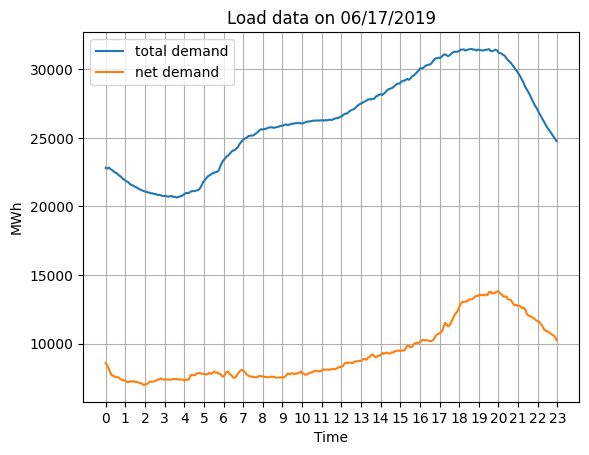

In [23]:
'''
Visualize total power demand.
'''
load_data = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').loc[[1,5]].to_numpy()
y1 = load_data[0][1:]
y2 = load_data[1][1:]
plt.plot(y1)
plt.plot(y2)
plt.title('Load data on 06/17/2019')
plt.xlabel('Time')
plt.ylabel('MWh')
plt.xticks(np.arange(0,300,12.5),labels=[str(x) for x in range(0,24)])
plt.legend(['total demand','net demand'])
plt.grid()
plt.show()

In [ ]:
res = []
emi_by_type = []
pg_time_by_type = []
eng = matlab.engine.start_matlab()
h = 0
counties = pd.read_csv("Result/carbon_intensity_0617_27.csv").to_numpy()[:,3]
for i in range(len(real_gen)):
    #qd = np.concatenate((qd, np.zeros((1743,))))
    r = eng.myFunc(real_gen[i])
    m = eng.loadcase('CaliforniaTestSystem.m')
    #power_d = np.array(m['bus'])[:,2]
    #np.array(m['bus'])[:,2] = power_demand
    #np.array(m['gen'])[:,1] = power_generation
    #eng.savecase('CaliforniaTestSystem.m', m)
    !julia run_opf.jl
    f = open("pf_solution.json")
    sol = json.load(f)
    # gen to bus
    gen = [-1]*num_gen
    gen_cost = [0]*num_gen
    power_generation = [0]*num_gen
    carbon_emission = [0]*num_gen
    power_generation_by_type = [0]*9
    emission_by_type = [0]*9
    for line, val in sol['solution']['gen'].items():
        if val['pg'] > 0.0:
            gen[int(line)-1] = df[int(line)-1][2]-1
            power_generation_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100
            carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
            gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
            gen_cost[int(line)-1] = val['pg_cost']
            power_generation[int(line)-1] = val['pg']*100
            emission_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100*type_to_emission[df[int(line)-1][3]]

    for line, val in sol['solution']['branch'].items():
        branch_power_from[int(line)-1] = round(val['pf']*100, 4)
        branch_power_to[int(line)-1] = round(val['pt']*100, 4)
        
    pg_time_by_type.append(power_generation_by_type)
    emi_by_type.append(emission_by_type)
    f.close()
    r = eng.myFuncNoModi(total_dem[i])
    m2 = eng.loadcase('CaliforniaTestSystem2.m')
    l_ori = np.array(m2['bus'])[:,2]
    power_demand = np.array(m['bus'])[:,2]
    print("power demand: " + str(sum(power_demand)))
    print("power gen: " + str(sum(power_generation)))
    print("real gen: " + str(real_gen[i]))
    '''graph = collections.defaultdict(list) # from: (to, line)
    graph_reverse = collections.defaultdict(list) # to: (from, line)
    for i, (from_bus, to_bus) in enumerate(line_to_nodes):
        graph[from_bus].append((to_bus, i))
        graph_reverse[to_bus].append((from_bus, i))'''
    for i, f in enumerate(branch_power_from):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph[from_node].remove((to_node, i))
            graph[to_node].append((from_node, i))
            graph_reverse[to_node].remove((from_node, i))
            graph_reverse[from_node].append((to_node, i))
            branch_power_from[i] = -f
    UNVISITED = -1
    id = [0]
    sccCount = [0]
    ids = [0]*num_bus
    low = [0]*num_bus
    onStack = [False]*num_bus
    stack = []
    def findSccs():
        for i in range(num_bus): ids[i] = UNVISITED
        for i in range(num_bus):
            if ids[i] == UNVISITED:
                tarjan_dfs(i)
        return low
    #print(pg_time_by_type)
    sccs = collections.defaultdict(list)
    seen = []
    edges = findSccs()
    for i, v in enumerate(edges):
        if v in seen:
            sccs[v].append(i)
            sccs[v].append(seen.index(v))
        seen.append(v)
    cycles = set()
    for k, v in sccs.items():
        cycles.add(frozenset(v))
    for c in cycles:
        c = list(c)
        total_demand = 0
        total_gen = 0
        for b in c:
            total_demand += power_demand[b]
            idx = gen.index(b) if b in gen else -1
            if idx != -1:
                total_gen += power_generation[idx]
        power_demand[c[0]] = total_demand
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            power_generation[gen.index(c[0])] = total_gen
        graph = update_graph_DAG(graph, c)
    graph_reverse = collections.defaultdict(list)
    for f, v in graph.items():
        for t, line in v:
            graph_reverse[t].append((f, line))
    # check we can process all nodes with kahn algo
    in_d = topo_order_kahn(graph)
    for i, v in enumerate(in_d):
        if v > 0:
            print("Following buses unprocessed: " + str(i))
    # Since the power generation can be negative, we can convert them to power demand instead
    for i, v in enumerate(power_generation):
        if v < 0.0:
            power_demand[gen[i]] -= v
            power_generation[i] = 0.0
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)
    for i, g in enumerate(gen):
        visited = set()
        dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    '''for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            # cannot directly set to 1.0 since the only the first node connected to gen should be set to zero. use gen[gen] = bus
            #bus_prop_mat[idx][int(k)] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            # same for line
            #line_prop_mat[idx][int(k)] = 1.0
    for i, v in enumerate(gen):
        if v != -1 and power_demand[v] > 0.0:
            bus_prop_mat[i][v] = power_generation[i]/power_demand[v]'''
    #(sum(bus_prop_mat[:, 1398]))
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse.items():
        in_degree[i] = len(v)
    q = set() # list of nodes with no inflow
    topo_order = []
    for g in gen:
        if g != -1 and in_degree[g] == 0:
            q.add(g)
    q = list(q)
    visited = set()
    print("Initial indegree: " + str(in_degree[2404]))
    while q:
        cur = int(q.pop(0))
        visited.add(cur)
        #if len(node_to_gen[cur]) > 1:
        out_total = power_demand[cur]
        for nei, out_line in graph[cur]:
            out_total += branch_power_from[out_line]
        
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            if cur == g:
                if out_total > 0.0: 
                    bus_prop_mat[idx][cur] = power_generation[idx]/out_total
            else:
                for nei, in_line in graph_reverse[cur]:
                    if out_total > 0.0:
                        bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            for nei, out_line in graph[cur]:
                line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]
        topo_order.append(cur)
        for nei, line in graph[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0 and nei not in visited:
                q.append(nei)
    avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat
    carbon_vec = np.zeros((num_bus, 1), dtype=float)
    bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
    for i in range(num_gen):
        s = np.sum(bus_prop_mat[i])
        for j in range(num_bus):
            if s != 0.0:
                bus_prop_mat_2[i][j] = bus_prop_mat[i][j]/s
    
    l_ren = np.reshape(l_ori, (1, num_bus)) - np.matmul(np.reshape(power_generation, (1, num_gen)), bus_prop_mat_2)
    l_ren = np.reshape(l_ren, (num_bus, 1))
    print("Total num of buses visited: " + str(len(visited)))
    break
    '''for i, v in enumerate(l_ren):
        if v < 0:
            l_ren[i] = 0'''
    #for i in range(num_bus):
        #for j in range(num_gen):
            #carbon_vec[i] += bus_prop_mat_2[j,i] * power_generation[j] * carbon_emission[j]
    total_carbon = sum(carbon_vec)
    res.append(total_carbon)
    ce = pd.read_csv("GIS/CATS_buses.csv")
    #ce.insert(2, 'carb_inten_only_renew', v)
    #ce.insert(3, 'pd', power_demand)
    #ce.insert(2, 'county', counties)
    #ce['carb_emit'] = ce['carb_inten_only_renew']*ce['pd']
    #tte = ce.groupby(['county'])['carb_emit'].agg('sum')
    #ttpd = ce.groupby(['county'])['pd'].agg('sum')
    #(tte/ttpd).to_frame().to_csv('Result/201906_county/carbon_intensity_0617_27_county_onlyrenew' + str(h) + '.csv')
    l_ori = np.reshape(l_ori, (num_bus, 1))
    carb_inten = np.divide(carbon_vec, l_ori, out=np.zeros_like(carbon_vec), where=l_ori!=0)
    #ce.insert(2, 'carb_inten', carb_inten)
    #ce.insert(2, 'renew_load', np.reshape(l_ren, (8870,)))
    #ce.to_csv('Result/201906/0617_all_' + str(h) + '.csv')
    avg_carbon_emission_rate_renew_time = []
    b = l_ori - l_ren
    a = np.multiply(np.reshape(avg_carbon_emission_rate_node, (num_bus, 1)), b)
    avg_carbon_emission_rate_renew = np.divide(a, l_ori, out=np.zeros_like(a), where=l_ori>0.0001)
    avg_carbon_emission_rate_renew_time.append(avg_carbon_emission_rate_renew)
    
    ce.insert(2, 'carb_inten_inc_all', avg_carbon_emission_rate_renew)
    ce.insert(1, 'carb_inten_no_renew', avg_carbon_emission_rate_node)
    ce.insert(1, 'l_ren', np.reshape(l_ren, (8870,)))
    ce.insert(3, 'pd', power_demand)
    ce.insert(2, 'county', counties)
    ce.insert(2, 'c_vec', carbon_vec)
    
    ce.to_csv('Result/201906/0617_all_' + str(h) + '.csv')
    ce['carb_emit'] = ce['carb_inten_no_renew']*ce['pd']
    tte = ce.groupby(['county'])['carb_emit'].agg('sum')
    llr = ce.groupby(['county'])['l_ren'].agg('sum')
    ttpd = ce.groupby(['county'])['pd'].agg('sum')
    #ce.groupby(['county'])['l_ren'].agg('sum').to_frame().to_csv('Result/201906_county/l_ren_0617_' + str(h) + '.csv')
    (tte/ttpd).to_frame().to_csv('Result/201906_county/carbon_intensity_0617_27_county_all_' + str(h) + '.csv')
    #ppd.to_frame().to_csv('Result/201906_county/pd_0617_27_county_all_' + str(h) + '.csv')
    #llr.to_frame().to_csv('Result/201906_county/l_ren_0617_27_county_all_' + str(h) + '.csv')
    h += 1
    break
eng.quit()

The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 14422.999999133779
power gen: 14423.00072770102
real gen: 14423
Initial indegree: 0
Total num of buses visited: 1672


In [232]:
for i, v in in_degree.items():
    if v == 0 and i not in visited:
        print(i)

In [233]:
max(np.sum(bus_prop_mat, axis=0))

1.0001143021095154

In [221]:
power_demand[8839]

0.0

In [222]:
graph[8839]

[]

In [209]:
for i, v in in_degree.items():
    if v == 0 and i not in visited:
        print(i)

1660


In [206]:
in_degree[4714]

0

In [205]:
for i,v in in_degree.items()

2134

In [192]:
node_to_gen[1660]

set()

In [153]:
bus_prop_mat[184, 1692]

39.47974338965996

In [159]:
for i, v in enumerate(gen):
    if v == 630:
        print(i)

In [92]:
gen[2139]

6773

In [163]:
power_demand[630]

0.0

In [169]:
branch_power_from[3712]*0.6243905495027176/branch_power_from[3714]

1.8838509592339112

In [161]:
graph[630]

[(652, 3714)]

In [162]:
graph_reverse[630]

[(4183, 3712)]

In [108]:
branch_power_from[8395] + branch_power_from[8398] + branch_power_from[8399] - branch_power_from[428] - branch_power_from[450] - branch_power_from[10302]

0.0

In [111]:
line_prop_mat[2139][8399]

1.0

In [101]:
power_demand[7887]

0.0

In [107]:
for i, v in enumerate(bus_prop_mat[:,7887]):
    if v > 0.0:
        print(i)

2139


In [62]:
renew = pd.read_csv('data/201906/CAISO-renewables-20190617.csv').iloc[[2]].to_numpy().reshape((289,))[1:]
renew_gen = []
for i in range(0,288):
    if i%12 == 0:
        renew_gen.append(renew[i])
pg_time_by_type = np.array(pg_time_by_type).T
pg_time_by_type_copy = pg_time_by_type.copy()

In [63]:
asu = pd.read_csv("data/201906/CAISO-supply-20190617.csv").to_numpy()[:,1:].T
actual_supply = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply.append(list(asu[i,:]))
actual_supply = np.array(actual_supply).T

In [64]:
pg_time_by_type_copy[2] += pg_time_by_type_copy[3] + pg_time_by_type_copy[4] + renew_gen

In [65]:
def get_MAPE(t, m):
    res = 0
    for i in range(len(t)):
        res += abs((t[i] - m[i])/t[i])
    res /= len(t)
    return res

In [66]:
def get_wMAPE(t, m):
    a = 0
    b = 0
    for i in range(len(t)):
        a += abs((t[i] - m[i]))
        b += abs(t[i])
    return a/b

In [67]:
real_t_g = actual_supply[1] + actual_supply[4] + actual_supply[5] + actual_supply[6]
t_g = pg_time_by_type_copy[1] + pg_time_by_type_copy[6] + pg_time_by_type_copy[7] + pg_time_by_type_copy[5]
get_MAPE(real_t_g, t_g)

0.4108163952688577

In [68]:
get_wMAPE(real_t_g, t_g)

0.37319806682833184

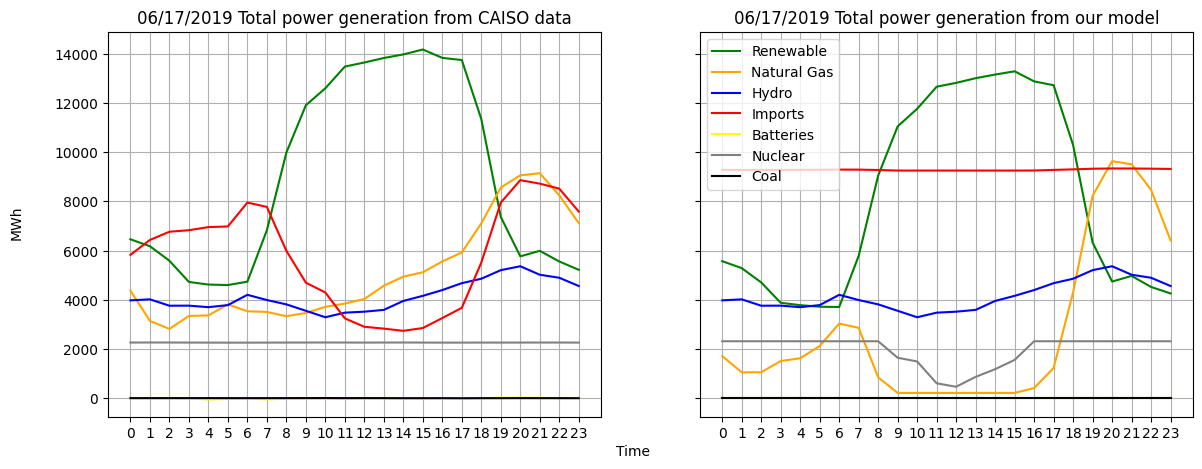

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
x = [i for i in range(0, 24, 1)]
ax1.plot(x, actual_supply[0], label='Renewable', color='green')
ax1.plot(x, actual_supply[1], label='Natural Gas', color='orange')
ax1.plot(x, actual_supply[2], label='Hydro', color='blue')
ax1.plot(x, actual_supply[3], label='Imports', color='red')
ax1.plot(x, actual_supply[4], label='Batteries', color='yellow')
ax1.plot(x, actual_supply[5], label='Nuclear', color='grey')
ax1.plot(x, actual_supply[6], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'MWh', ha='center', va='center', rotation='vertical')
ax1.grid()
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("06/17/2019 Total power generation from CAISO data")
ax2.plot(x, pg_time_by_type_copy[2], label='Renewable', color='green')
ax2.plot(x, pg_time_by_type_copy[1], label='Natural Gas', color='orange')
ax2.plot(x, actual_supply[2], label='Hydro', color='blue')
ax2.plot(x, pg_time_by_type_copy[0], label='Imports', color='red')
ax2.plot(x, pg_time_by_type_copy[6], label='Batteries', color='yellow')
ax2.plot(x, pg_time_by_type_copy[7], label='Nuclear', color='grey')
ax2.plot(x, pg_time_by_type_copy[5], label='Coal', color='black')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("06/17/2019 Total power generation from our model")
ax2.legend()
ax2.grid()
#fig.tight_layout()

In [61]:
te = pd.read_csv("data/201906/CAISO-co2-per-resource-20190617.csv").to_numpy()[:,1:].T
target_emissions = []
for i in range(0,288):
    if i%12 == 0:
        target_emissions.append(list(te[i,:]))
carb_e_rate = []
pg_time_by_type = np.array(pg_time_by_type[:6,:])
target_emissions = np.array(target_emissions).T

In [62]:
carb_total = np.reshape(np.array(res).T + target_emissions[0], (24,))

In [573]:
'''actual_supply_renew = pd.read_csv("data\CAISO-supply-20190712 - Copy.csv").to_numpy()[:,1:].T
actual_supply_renew_ = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply_renew_.append(list(actual_supply_renew[i,:]))
actual_supply_renew_ = np.array(actual_supply_renew_).T'''

In [63]:
tt = pd.read_csv("data/201906/CAISO-co2-20190617.csv").to_numpy()[:,1:].T
real_total_e = []
for i in range(0,288):
    if i%12 == 0:
        real_total_e.append(tt[i])

In [64]:
get_wMAPE(real_total_e, carb_total)

array([0.49802725824910166], dtype=object)

In [65]:
get_MAPE(real_total_e, carb_total)

array([0.5036894200851442], dtype=object)

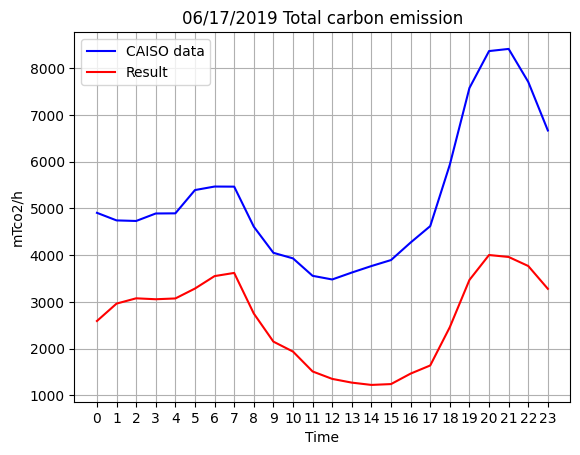

In [66]:
x = [i for i in range(0, 24, 1)]
plt.plot(x, real_total_e, color='b', label='CAISO data')
plt.xlabel("Time")
plt.ylabel("mTco2/h")
plt.xticks(x)
plt.plot(x, carb_total, color='r', label='Result')
plt.title("06/17/2019 Total carbon emission")
plt.legend()
plt.grid()
plt.savefig('foo.png')

In [67]:
emi_by_type = np.array(emi_by_type).T

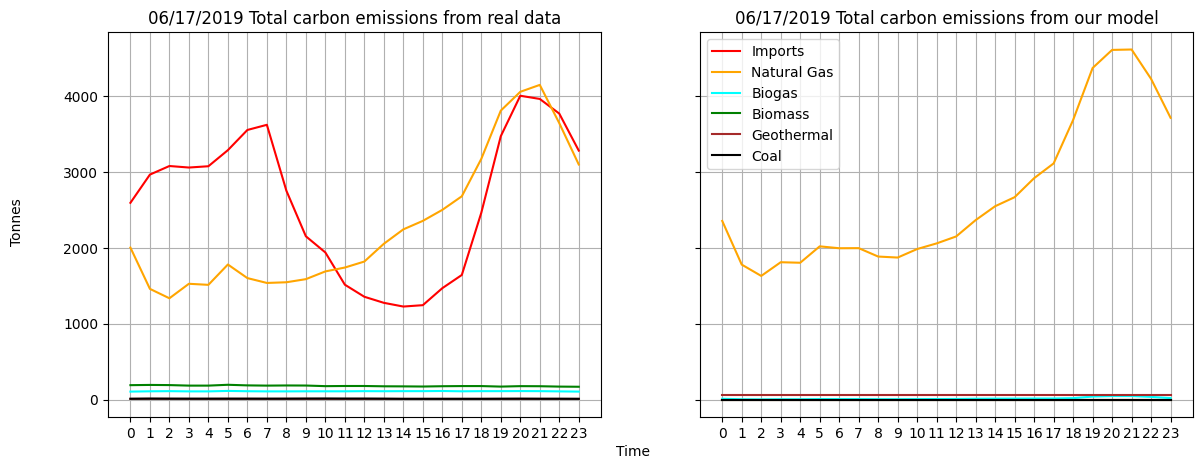

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
#fig.suptitle('Comparison of carbon emissions by fuel type')
x = [i for i in range(0, 24, 1)]
ax1.plot(x, target_emissions[0], label='Imports', color='red')
ax1.plot(x, target_emissions[1], label='Natural Gas', color='orange')
ax1.plot(x, target_emissions[2], label='Biogas', color='cyan')
ax1.plot(x, target_emissions[3], label='Biomass', color='green')
ax1.plot(x, target_emissions[4], label='Geothermal', color='brown')
ax1.plot(x, target_emissions[5], label='Coal', color='black')
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("06/17/2019 Total carbon emissions from real data")
ax1.grid()
ax2.plot(x, emi_by_type[0], label='Imports', color='red')
ax2.plot(x, emi_by_type[1], label='Natural Gas', color='orange')
ax2.plot(x, emi_by_type[2], label='Biogas', color='cyan')
ax2.plot(x, emi_by_type[3], label='Biomass', color='green')
ax2.plot(x, emi_by_type[4], label='Geothermal', color='brown')
ax2.plot(x, emi_by_type[5], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Tonnes', ha='center', va='center', rotation='vertical')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("06/17/2019 Total carbon emissions from our model")
ax2.legend()
ax2.grid()
plt.savefig('foo.png')
#fig.tight_layout()